In [28]:
import torch
import numpy as np
import scanpy as sc
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path

In [29]:
# Load transcriptomics data
visium_path = Path("V11L12-109_B1/output_data/V11L12-109_B1_RNA/outs")
adata = sc.read_visium(path=visium_path)

adata.var_names_make_unique()

# Specify species ('human' or 'mouse')
species = 'mouse'  # Change this to 'human' if analyzing human data

# Identify mitochondrial genes based on species
mt_prefix = 'MT-' if species == 'human' else 'mt-'
adata.var['mt'] = adata.var_names.str.startswith(mt_prefix)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Additional QC filtering
adata = adata[adata.obs.pct_counts_mt <= 38, :]  # Remove spots with mitochondrial genes > 38%
adata = adata[adata.obs.n_genes_by_counts >= 50, :]  # Remove spots with fewer than 50 genes expressed

# Remove specific gene categories based on species
if species == 'human':
    genes_remove_prefixes = ('HB', 'Hb', 'RPS', 'RPL', 'MALAT1', 'Malat1')
else:
    genes_remove_prefixes = ('Hba', 'Hbb', 'Rps', 'Rpl', 'Malat1')

# Apply gene filtering
genes_remove = adata.var_names[adata.var_names.str.startswith(genes_remove_prefixes)]
adata = adata[:, ~adata.var_names.isin(genes_remove)]

# Normalize gene expression (total expression per spot to 10,000)
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)

# Log-transform
sc.pp.log1p(adata)

# Highly variable genes (Seurat method)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

# Keep only highly variable genes
gene_expression = adata.to_df()
high_variance_genes = adata.var[adata.var["highly_variable"]].index
gene_expression = gene_expression[high_variance_genes]

print(f"Selected {len(high_variance_genes)} highly variable genes for analysis.")
gene_expression

/Users/dubingxue/opt/anaconda3/envs/smt/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/dubingxue/opt/anaconda3/envs/smt/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/dubingxue/opt/anaconda3/envs/smt/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Selected 2000 highly variable genes for analysis.


,Adhfe1,Vxn,1700034P13Rik,Cspp1,Lactb2,Rdh10,Gsta3,Phf3,Uggt1,Arid5a,...,Gprasp1,Gprasp2,Psmd10,Tmem29,Alas2,Sat1,Sh3kbp1,Gpm6b,CAAA01118383.1,CR974586.4
AAACAAGTATCTCCCA-1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,1.402562,0.000000,0.000000,0.0,0.0,0.0,1.402562,1.964481,0.000000,0.0
AAACATTTCCCGGATT-1,1.042825,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,1.542110,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.873595,0.000000,0.0
AAACCCGAACGAAATC-1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.821102,0.000000,0.0
AAACCGGAAATGTTAA-1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,1.898907,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.898907,0.000000,0.0
AAACCGGGTAGGTACC-1,0.000000,0.000000,0.0,0.762384,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.762384,0.762384,0.762384,0.0,0.0,0.0,0.000000,1.718027,0.762384,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,0.000000,1.395553,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,1.714844,0.000000,1.395553,0.0,0.0,0.0,0.000000,1.714844,0.000000,0.0
TTGTTCTAGATACGCT-1,0.000000,1.053046,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,1.886934,1.053046,0.000000,0.0,0.0,0.0,0.000000,1.053046,1.053046,0.0
TTGTTGTGTGTCAAGA-1,0.000000,0.913569,0.0,0.000000,0.0,0.0,0.0,0.913569,0.0,0.000000,...,1.701035,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.701035,0.000000,0.0
TTGTTTCCATACAACT-1,0.845094,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.296478,...,1.842578,1.296478,0.000000,0.0,0.0,0.0,0.845094,1.296478,0.000000,0.0


In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# =============================
# Load MSI data
# =============================
msi_data_path = Path("V11L12-109_B1/output_data/V11L12-109_B1_MSI/V11L12-109_B1.Visium.FMP.220826_smamsi.csv")
msi_data = pd.read_csv(msi_data_path)

# Extract spatial coordinates
msi_coords = msi_data[['x', 'y']]

# Extract metabolite intensity matrix
msi_metabolites = msi_data.iloc[:, 2:]

# =============================
# Compute total ion current (TIC) and remove zero-TIC spots
# =============================
msi_data['TIC'] = msi_data.iloc[:, 2:].sum(axis=1)

# Remove spots with zero TIC
msi_data_filtered = msi_data[msi_data['TIC'] > 0].reset_index(drop=True)
print("Number of spots after removing zero-TIC entries:", len(msi_data_filtered))

# Update coordinates and metabolite matrix
msi_coords_filtered = msi_data_filtered[['x', 'y']].reset_index(drop=True)
msi_metabolites_filtered = msi_data_filtered.iloc[:, 2:-1]  # metabolite features
tic_values = msi_data_filtered['TIC'].reset_index(drop=True)  # store TIC values

# TIC normalization (scale total intensity per spot to 10,000)
target_total = 10000  # target total intensity per spot
msi_metabolites_norm = (
    msi_metabolites_filtered
    .div(msi_metabolites_filtered.sum(axis=1), axis=0)
    * target_total
)

# Log transformation (log1p)

msi_metabolites_log = np.log1p(msi_metabolites_norm)

# Combine spatial coordinates and processed metabolite features

final_msi_df = pd.concat(
    [msi_coords_filtered.reset_index(drop=True),
     msi_metabolites_log.reset_index(drop=True),
     tic_values],
    axis=1
)

# Ensure TIC column is included
final_msi_df['TIC'] = tic_values

# Inspect the final processed data
print("Final processed MSI data:")
print(final_msi_df.head())
msi_data = final_msi_df

Number of spots after removing zero-TIC entries: 3005
Final processed MSI data:
   x   y  156.26059  156.26195  156.48344  156.4838  156.485  157.54681  \
0  0  55   0.000000        0.0        0.0       0.0      0.0   0.000000   
1  0  56   0.000000        0.0        0.0       0.0      0.0   0.000000   
2  0  57   0.312137        0.0        0.0       0.0      0.0   0.311731   
3  1  52   0.000000        0.0        0.0       0.0      0.0   0.000000   
4  1  53   0.000000        0.0        0.0       0.0      0.0   0.000000   

   158.41217  160.02547  ...  1044.3523  1046.31366  1046.32671  1046.33977  \
0   0.027037        0.0  ...        0.0    0.000000    0.000000    0.000000   
1   0.101571        0.0  ...        0.0    0.000000    0.375490    0.784505   
2   0.000000        0.0  ...        0.0    0.593231    0.703041    0.000000   
3   0.000000        0.0  ...        0.0    0.000000    0.000000    0.000000   
4   0.000000        0.0  ...        0.0    0.000000    0.000000    0.58803

In [31]:
# Check whether spatial information is present in adata.uns
if "spatial" not in adata.uns:
    raise KeyError("The 'spatial' key is missing in adata.uns.")

# Retrieve spatial metadata
spatial_info = adata.uns["spatial"]

# Retrieve sample ID (usually only one sample is present)
sample_id = list(spatial_info.keys())[0]
print(f"Sample ID: {sample_id}")

# Retrieve scaling factor for high-resolution image
scale_factor = spatial_info[sample_id]["scalefactors"]["tissue_hires_scalef"]

# Retrieve high-resolution tissue image
tissue_hires_image = adata.uns["spatial"][sample_id]["images"]["hires"]

# Get image height and width
img_height, img_width = tissue_hires_image.shape[:2]

print(f"Scale factor: {scale_factor}")


Sample ID: V11L12-109_B1
Scale factor: 0.04155585


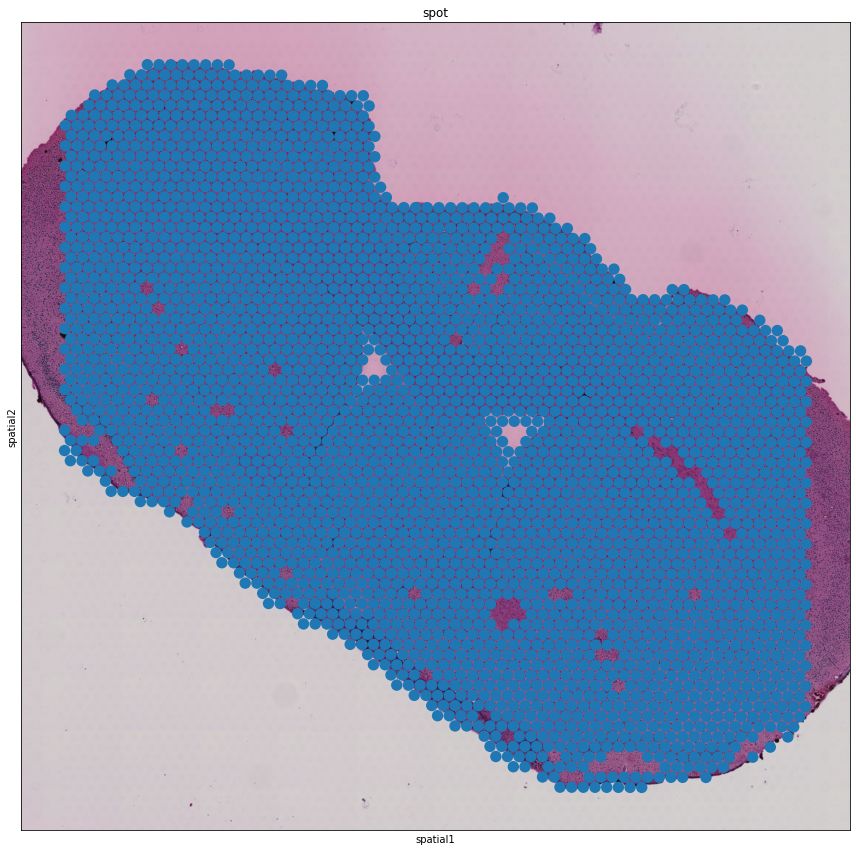

In [32]:
import matplotlib.pyplot as plt
import scanpy as sc

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Ensure that the "spot" column exists in adata.obs
if "spot" not in adata.obs.columns:
    adata.obs["spot"] = "default"  # Add a default column if no specific spot annotation is available

# Spatial visualization
sc.pl.spatial(
    adata,
    img_key="hires",     # Use the high-resolution tissue image
    color="spot",        # Replace with the actual column name if available
    size=1.5,            # Spot size
    legend_loc="right",  # Display legend on the right side
    show=False,
    ax=ax,               # Draw on the current axis
)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [33]:
# Obtain the pixel coordinate range of RNA data
rna_pixel_coords = adata.obsm["spatial"] * scale_factor  # Apply the H&E image scaling factor
rna_x_min, rna_x_max = rna_pixel_coords[:, 0].min(), rna_pixel_coords[:, 0].max()
rna_y_min, rna_y_max = rna_pixel_coords[:, 1].min(), rna_pixel_coords[:, 1].max()

# Obtain the original coordinate range of MSI data
msi_x_min, msi_x_max = msi_data["x"].min(), msi_data["x"].max()
msi_y_min, msi_y_max = msi_data["y"].min(), msi_data["y"].max()

# Compute scaling factors for x and y directions
scale_x = img_width / (msi_x_max - msi_x_min)
scale_y = img_height / (msi_y_max - msi_y_min)

# Align MSI coordinates to the image space
msi_data["x_aligned"] = (msi_data["x"] - msi_x_min) * scale_x
msi_data["y_aligned"] = (msi_data["y"] - msi_y_min) * scale_y

# Optional: swap x and y coordinates for mirrored alignment if needed
# msi_data[["x_aligned", "y_aligned"]] = msi_data[["y_aligned", "x_aligned"]].values


Selected metabolite column: TIC


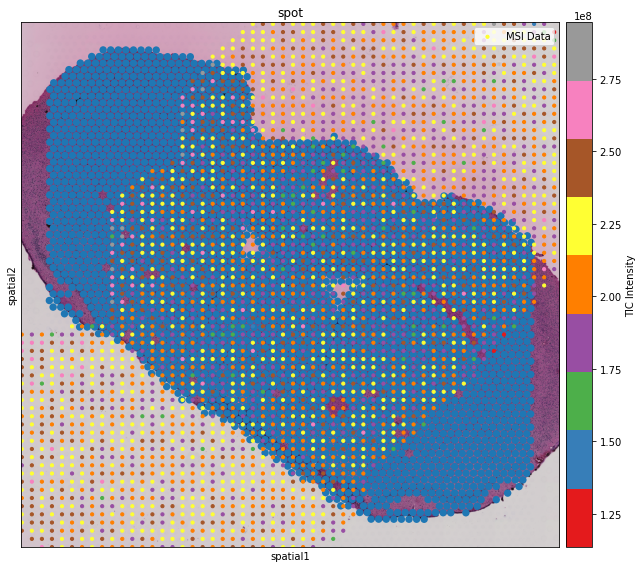

In [34]:
# Alignment test

# Dynamically select a metabolite column
metabolite_column = msi_data.columns[1540]  # Select a metabolite column (assuming x and y are the first two columns)
print(f"Selected metabolite column: {metabolite_column}")

import matplotlib.pyplot as plt
import scanpy as sc

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Spatial visualization of RNA data points
sc.pl.spatial(
    adata,
    img_key="hires",       # Use the high-resolution tissue image
    color="spot",          # Replace with the RNA annotation column if available
    size=1.5,              # Spot size
    legend_loc="right",    # Display legend on the right side
    show=False,
    ax=ax                  # Draw on the current axis
)

# Overlay MSI data points
ax.scatter(
    msi_data["x_aligned"],           # X coordinates of MSI data
    msi_data["y_aligned"],           # Y coordinates of MSI data
    c=msi_data[metabolite_column],   # Color by metabolite intensity
    cmap="Set1",
    s=10,                            # Marker size
    label="MSI Data"                 # Legend label
)

# Add colorbar and legend
cbar = plt.colorbar(
    ax.collections[-1],
    ax=ax,
    pad=0.01,
    label=f"{metabolite_column} Intensity"
)
ax.legend(loc="upper right")  # Legend position

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


In [35]:
import numpy as np

# 1. Extract aligned MSI coordinates
x = msi_data["x_aligned"].values
y = msi_data["y_aligned"].values

# 2. Apply isotropic scaling around the centroid
scale = 0.79  # scaling factor
x_center, y_center = np.mean(x), np.mean(y)
x = (x - x_center) * scale + x_center
y = (y - y_center) * scale + y_center

# 3. Apply rotation around the centroid
angle_deg = 84  # rotation angle in degrees
angle_rad = np.deg2rad(angle_deg)

x_rot = (
    np.cos(angle_rad) * (x - x_center)
    - np.sin(angle_rad) * (y - y_center)
    + x_center
)
y_rot = (
    np.sin(angle_rad) * (x - x_center)
    + np.cos(angle_rad) * (y - y_center)
    + y_center
)

x, y = x_rot, y_rot  # update rotated coordinates

# 4. Apply translation
tx, ty = 0, 40  # translation offsets (x, y)
x = x + tx
y = y + ty

# 5. Store transformed coordinates back to the dataframe
msi_data["x_aligned"] = x
msi_data["y_aligned"] = y


Selected metabolite column: TIC


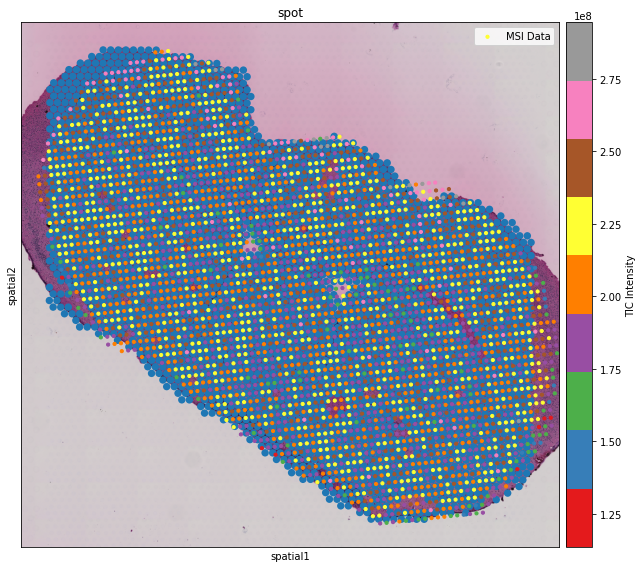

In [36]:
# Alignment test

import matplotlib.pyplot as plt
import scanpy as sc

# Dynamically select a metabolite column
metabolite_column = msi_data.columns[1540]  # Select a metabolite column (assuming x and y are the first two columns)
print(f"Selected metabolite column: {metabolite_column}")

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Spatial visualization of RNA data points
sc.pl.spatial(
    adata,
    img_key="hires",       # Use the high-resolution tissue image
    color="spot",          # Replace with an RNA annotation column if available
    size=1.5,              # Spot size
    legend_loc="right",    # Display legend on the right side
    show=False,
    ax=ax                  # Draw on the current axis
)

# Overlay MSI data points
ax.scatter(
    msi_data["x_aligned"],           # X coordinates of aligned MSI data
    msi_data["y_aligned"],           # Y coordinates of aligned MSI data
    c=msi_data[metabolite_column],   # Color by metabolite intensity
    cmap="Set1",
    s=10,                            # Marker size
    label="MSI Data"                 # Legend label
)

# Add colorbar and legend
plt.colorbar(
    ax.collections[-1],
    ax=ax,
    pad=0.01,
    label=f"{metabolite_column} Intensity"
)
ax.legend(loc="upper right")

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


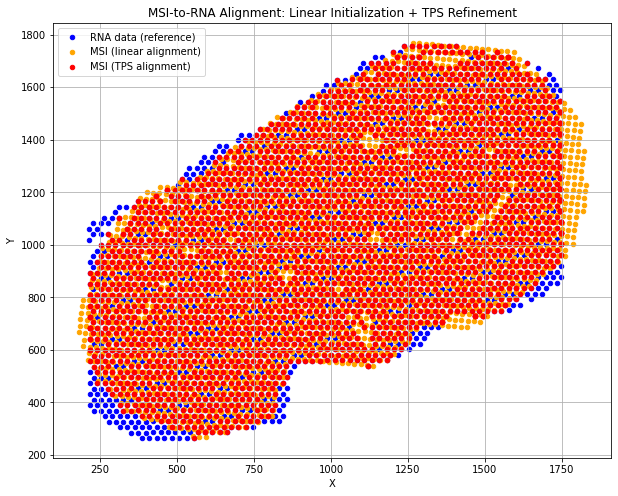

In [37]:
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

# Retrieve linearly aligned MSI coordinates
msi_coords_aligned_linear = msi_data[["x_aligned", "y_aligned"]].values

# Automatically generate landmark pairs via nearest-neighbor matching
kd_tree = cKDTree(rna_pixel_coords)
distances, indices = kd_tree.query(msi_coords_aligned_linear)

msi_keypoints = msi_coords_aligned_linear
rna_keypoints = rna_pixel_coords[indices]

# Nonlinear alignment using Thin Plate Spline (TPS)
rbf_x = Rbf(
    msi_keypoints[:, 0],
    msi_keypoints[:, 1],
    rna_keypoints[:, 0],
    function="thin_plate"
)
rbf_y = Rbf(
    msi_keypoints[:, 0],
    msi_keypoints[:, 1],
    rna_keypoints[:, 1],
    function="thin_plate"
)

msi_data["x_aligned_tps"] = rbf_x(
    msi_coords_aligned_linear[:, 0],
    msi_coords_aligned_linear[:, 1]
)
msi_data["y_aligned_tps"] = rbf_y(
    msi_coords_aligned_linear[:, 0],
    msi_coords_aligned_linear[:, 1]
)

# Visualize alignment results
plt.figure(figsize=(10, 8))

plt.scatter(
    rna_pixel_coords[:, 0],
    rna_pixel_coords[:, 1],
    c="blue",
    label="RNA data (reference)",
    s=20
)

plt.scatter(
    msi_coords_aligned_linear[:, 0],
    msi_coords_aligned_linear[:, 1],
    c="orange",
    label="MSI (linear alignment)",
    s=20
)

plt.scatter(
    msi_data["x_aligned_tps"],
    msi_data["y_aligned_tps"],
    c="red",
    label="MSI (TPS alignment)",
    s=20
)

plt.legend()
plt.title("MSI-to-RNA Alignment: Linear Initialization + TPS Refinement")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


Selected metabolite column: TIC


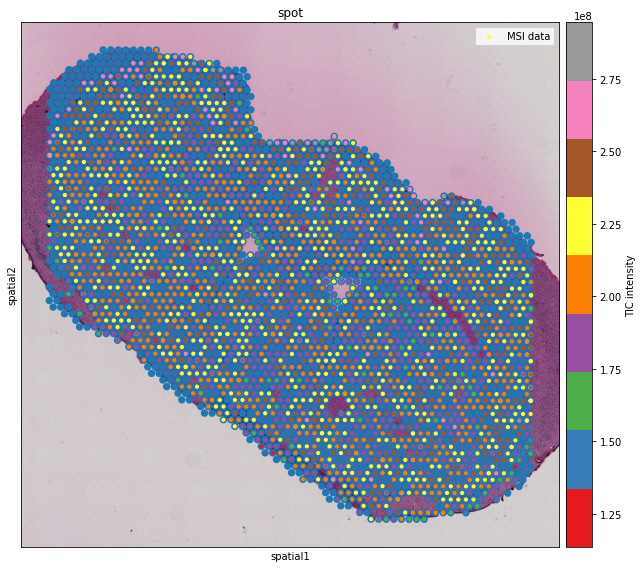

In [38]:
# Alignment test

import matplotlib.pyplot as plt
import scanpy as sc

# Dynamically select a metabolite column
metabolite_column = msi_data.columns[1540]  # Select a metabolite column 
print(f"Selected metabolite column: {metabolite_column}")

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Spatial visualization of RNA data points
sc.pl.spatial(
    adata,
    img_key="hires",       # Use the high-resolution tissue image
    color="spot",          # Replace with an RNA annotation column if available
    size=1.5,              # Spot size
    legend_loc="right",    # Display legend on the right side
    show=False,
    ax=ax                  # Draw on the current axis
)

# Overlay MSI data points (after TPS alignment)
ax.scatter(
    msi_data["x_aligned_tps"],          # X coordinates of TPS-aligned MSI data
    msi_data["y_aligned_tps"],          # Y coordinates of TPS-aligned MSI data
    c=msi_data[metabolite_column],      # Color by metabolite intensity
    cmap="Set1",
    s=10,                               # Marker size
    label="MSI data"                    # Legend label
)

# Add colorbar and legend
plt.colorbar(
    ax.collections[-1],
    ax=ax,
    pad=0.01,
    label=f"{metabolite_column} intensity"
)
ax.legend(loc="upper right")

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


In [39]:
import pandas as pd
from scipy.interpolate import griddata

# TPS-aligned MSI coordinates
msi_points = msi_data[["x_aligned_tps", "y_aligned_tps"]].values

# Metabolite intensity matrix (exclude coordinate and alignment-related columns)
msi_values = msi_data.iloc[:, 2:-5].values

# RNA pixel coordinates (reference grid)
rna_points = rna_pixel_coords

# Nearest-neighbor interpolation of MSI features onto RNA spots
aggregated_metabolites = griddata(
    msi_points,
    msi_values,
    rna_points,
    method="nearest"
)

# RNA spatial coordinates
rna_coords = pd.DataFrame(
    rna_pixel_coords,
    columns=["x", "y"],
    index=adata.obs_names
).reset_index().rename(columns={"index": "spot"})

# Processed gene expression matrix (e.g., highly variable genes)
rna_expression_df = gene_expression.reset_index(drop=True)

# Combine RNA coordinates and gene expression
rna_final_df = pd.concat([rna_coords, rna_expression_df], axis=1)

# Save aligned spatial transcriptomics data
rna_final_df.to_csv("aligned_ST_data.csv", index=False)

# Retrieve metabolite names
metabolite_names = msi_data.columns[2:-5]

# Create metabolite dataframe after interpolation
aggregated_metabolites_df = pd.DataFrame(
    aggregated_metabolites,
    columns=metabolite_names
)

# Combine RNA coordinates with interpolated metabolite features
aggregated_metabolites_df = pd.concat(
    [rna_coords.reset_index(drop=True), aggregated_metabolites_df],
    axis=1
)

# Save aligned spatial metabolomics data
aggregated_metabolites_df.to_csv("aligned_SM_data.csv", index=False)


In [40]:
from torch_geometric.data import Data
from scipy.spatial import distance_matrix
import torch
import numpy as np

# === Transcriptomics Data ===
transcript_data = Data(
    x=torch.tensor(gene_expression.values, dtype=torch.float),
    pos=torch.tensor(rna_pixel_coords, dtype=torch.float)
)

# === Metabolomics Data ===
metabolite_data = Data(
    x=torch.tensor(aggregated_metabolites, dtype=torch.float),
    pos=torch.tensor(rna_pixel_coords, dtype=torch.float)
)

# === Transcript-to-transcript edges ===
dist_matrix_tt = distance_matrix(rna_pixel_coords, rna_pixel_coords)
print(f"Transcript distance matrix stats: min={dist_matrix_tt.min()}, max={dist_matrix_tt.max()}, mean={dist_matrix_tt.mean()}")
dynamic_threshold_tt = np.percentile(dist_matrix_tt, 5)
print(f"Dynamic transcript threshold: {dynamic_threshold_tt}")

edges_tt = np.transpose(np.where((dist_matrix_tt < dynamic_threshold_tt) & (dist_matrix_tt > 0)))

if edges_tt.size > 0:
    adj_tt_tensor = torch.tensor(edges_tt, dtype=torch.long).t().contiguous()
    adj_tt_matrix = torch.zeros((len(rna_pixel_coords), len(rna_pixel_coords)))
    adj_tt_matrix[adj_tt_tensor[0], adj_tt_tensor[1]] = 1
    transcript_data.edge_index = adj_tt_tensor
    print(f"Generated {edges_tt.shape[0]} transcript-to-transcript edges.")
else:
    print("Warning: No transcript-to-transcript edges generated.")
    adj_tt_matrix = torch.zeros((len(rna_pixel_coords), len(rna_pixel_coords)))
    transcript_data.edge_index = torch.empty((2, 0), dtype=torch.long)

# === Metabolite-to-metabolite edges ===
dist_matrix_mm = distance_matrix(rna_pixel_coords, rna_pixel_coords)  
print(f"Metabolite distance matrix stats: min={dist_matrix_mm.min()}, max={dist_matrix_mm.max()}, mean={dist_matrix_mm.mean()}")
dynamic_threshold_mm = np.percentile(dist_matrix_mm, 5)  
print(f"Dynamic metabolite threshold: {dynamic_threshold_mm}")

num_spots = aggregated_metabolites.shape[0]

edges_mm = np.transpose(np.where(
    (dist_matrix_mm < dynamic_threshold_mm) & (dist_matrix_mm > 0)
))

if edges_mm.size > 0:
    adj_mm_tensor = torch.tensor(edges_mm, dtype=torch.long).t().contiguous()
    adj_mm_matrix = torch.zeros((num_spots, num_spots))
    adj_mm_matrix[adj_mm_tensor[0], adj_mm_tensor[1]] = 1
    metabolite_data.edge_index = adj_mm_tensor
    print(f"Generated {edges_mm.shape[0]} metabolite-to-metabolite edges.")
else:
    print("Warning: No metabolite-to-metabolite edges generated.")
    adj_mm_matrix = torch.zeros((num_spots, num_spots))
    metabolite_data.edge_index = torch.empty((2, 0), dtype=torch.long)

Transcript distance matrix stats: min=0.0, max=1957.6068182782833, mean=694.6679300594318
Dynamic transcript threshold: 168.95959095728784
Generated 456960 transcript-to-transcript edges.
Metabolite distance matrix stats: min=0.0, max=1957.6068182782833, mean=694.6679300594318
Dynamic metabolite threshold: 168.95959095728784
Generated 456960 metabolite-to-metabolite edges.


In [41]:
from torch_geometric.utils import add_self_loops

transcript_data.pos = torch.tensor(rna_pixel_coords, dtype=torch.float)
transcript_data.edge_index = adj_tt_matrix.nonzero(as_tuple=False).t()

metabolite_data.pos = torch.tensor(rna_pixel_coords, dtype=torch.float)
metabolite_data.edge_index = adj_mm_matrix.nonzero(as_tuple=False).t()

transcript_data.edge_index, _ = add_self_loops(
    transcript_data.edge_index, 
    num_nodes=transcript_data.x.size(0)
)
metabolite_data.edge_index, _ = add_self_loops(
    metabolite_data.edge_index, 
    num_nodes=metabolite_data.x.size(0)
)

print("Self-loops added successfully.")

# Save processed data 
torch.save({
    "transcript_data": transcript_data,
    "metabolite_data": metabolite_data,
}, "graph_data.pt")

print("Updated graph data and matched full information saved successfully.")

Self-loops added successfully.
Updated graph data and matched full information saved successfully.
